In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import colorcet as cc
import seaborn as sns
import rasterio as rio
import geopandas as gp

import fiona 
import rasterio
import rasterio.mask

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

from rasterio.mask import mask
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib.lines import Line2D      
from matplotlib.cm import get_cmap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm

import matplotlib.pyplot as plt
from collections import OrderedDict 

from osgeo import gdal, osr, ogr
from tqdm import tqdm

In [2]:
# Helpers

def plot_basemaps(image, shp, title = None, cmap = 'viridis', ax = None, latlabels = True, lonlabels = True, vmax = None):
    imextent = gp.read_file(shp).set_crs("EPSG:4326").to_crs(4326).total_bounds
    shape_feature = ShapelyFeature(Reader("../shape/sierra_catchments.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='white', facecolor = 'none')

    minx, miny, maxx, maxy = imextent
    lllon, lllat = minx, miny
    urlon, urlat = maxx, maxy

    # Create a Stamen Terrain instance.
    stamen_terrain = cimgt.GoogleTiles(style='terrain', url = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Shaded_Relief/MapServer/tile/{z}/{y}/{x}.jpg')

    # Create a GeoAxes in the tile's projection.
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels= False
    gl.right_labels = False
    if not latlabels:
        gl.left_labels = False
    if not lonlabels:
        gl.bottom_labels = False
    
    gl.xlocator = mticker.FixedLocator([-122,-121,-120,-119])
    gl.ylocator = mticker.FixedLocator(np.linspace(0,90,91))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 8, 'color': 'gray', 'rotation': 45}
    gl.ylabel_style = {'size': 9, 'color': 'gray'}

    # Limit the extent of the map to a small longitude/latitude range.
    ax.set_extent([lllon, urlon, lllat, urlat])

    # Add the Stamen data at zoom level 8.
    ax.add_image(stamen_terrain, 8)
    
    im = ax.imshow(image,
        cmap=cmap, zorder=1, vmin = 0, vmax = vmax,
        origin="upper", alpha = 0.8,
        extent=(lllon, urlon, lllat, urlat),
        transform=ccrs.PlateCarree(),
    )

    # Add shapefile outline
    ax.add_feature(shape_feature, zorder = 2)
    
    points = list(Reader("../shape/trm_res_fnf.shp").geometries())

    ax.scatter([point.x for point in points],
               [point.y for point in points],
               transform=ccrs.PlateCarree(), color= 'orange', s = 25, zorder = 10)
        
    # Set the title
    ax.set_title("{}".format(title), size = 12)

    return im

In [3]:
# read files setup dirs 
gdf = gp.read_file("../shape/sierra_catchments.shp")

stids = list(gdf['stid'].values)

# Define outdirs
results_dir = "../results/BF_xc_K180/"
outdir = os.path.join(results_dir,"merged")
clipdir = os.path.join(results_dir,"clipped")

if not os.path.exists(outdir):
    os.mkdir(outdir)
    
if not os.path.exists(clipdir):
    os.mkdir(clipdir)

# Clip by watershed into the clipped dir
for stn_id in stids[:]:
    
    print("****" * 15)
    print("PROCESSING : {}".format(stn_id))
    print("****" * 15)

    # get shapefile 
    catch_shp = os.path.abspath("../shape/{}.shp".format(stn_id))
    
    # Get files matching the wshed 
    wshed_files = [os.path.join(results_dir,x) for x in os.listdir(results_dir) if stn_id in x]
    wshed_files = [os.path.abspath(x) for x in wshed_files]
    
    for fn in wshed_files:
        varfn = os.path.split(fn)[1]
        outfn = os.path.join(clipdir,varfn) 
        if not os.path.exists(outfn):
            cmd = '''gdalwarp -dstnodata -999 -cutline {} -crop_to_cutline {} {}'''.format(catch_shp, fn, outfn)
            os.system(cmd)
    print("DONE ---")



************************************************************
PROCESSING : SJF
************************************************************
DONE ---
************************************************************
PROCESSING : TLG
************************************************************
DONE ---
************************************************************
PROCESSING : ISB
************************************************************
DONE ---
************************************************************
PROCESSING : NAT
************************************************************
DONE ---
************************************************************
PROCESSING : MHB
************************************************************
DONE ---
************************************************************
PROCESSING : NML
************************************************************
DONE ---
************************************************************
PROCESSING : ORO
**********************************

In [4]:
# Merge files 

prcp_files = [os.path.join(clipdir,x) for x in os.listdir(clipdir) if "prcp" in x]

# merge and write 
prcp_merged_fn = os.path.join(outdir,"prcp.tiff")
if not os.path.exists(prcp_merged_fn):
    g_prcp = gdal.Warp(prcp_merged_fn, prcp_files, format="GTiff")
    g_prcp = None # Close file
    print("WROTE {}".format(prcp_merged_fn))

In [5]:
smlt_files = [os.path.join(clipdir,x) for x in os.listdir(clipdir) if "smlt" in x]

smlt_merged_fn = os.path.join(outdir,"smlt.tiff")
if not os.path.exists(smlt_merged_fn):
    g_prcp = gdal.Warp(smlt_merged_fn, smlt_files, format="GTiff")
    g_prcp = None # Close file
    print("WROTE {}".format(smlt_merged_fn))


In [6]:
# Set the cmap 

cmap = get_cmap('cet_kbgyw')

/var/folders/zd/rjxfh38941s3dn35jv9cdgmw0000gn/T/ipykernel_7470/2597094362.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('cet_kbgyw')


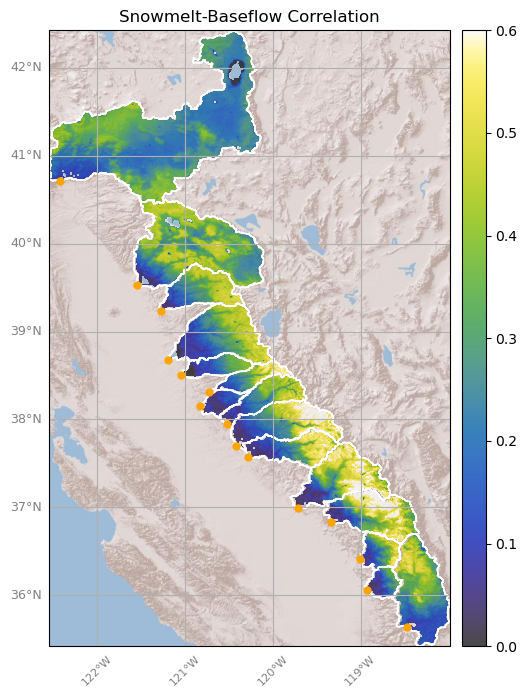

In [7]:
src = rio.open("../results/BF_xc_K180/merged/smlt.tiff")
arr = src.read(1)
arr[arr==src.nodata] = np.nan

# SUMs

fig, axes = plt.subplots(nrows=1, ncols=1,figsize = (12,8), subplot_kw={'projection': ccrs.PlateCarree()})
im = plot_basemaps(arr, "../shape/sierra_catchments.shp", "Snowmelt-Baseflow Correlation", cmap = cmap, ax = axes, latlabels = True, lonlabels = True, vmax = 0.6)
fig.subplots_adjust(wspace=0.02,hspace = 0.00)
cax = fig.add_axes([axes.get_position().x1+0.01,axes.get_position().y0,0.02,axes.get_position().y1-axes.get_position().y0])
fig.colorbar(mappable = im, orientation='vertical', cax = cax,ax = axes)

plt.show()


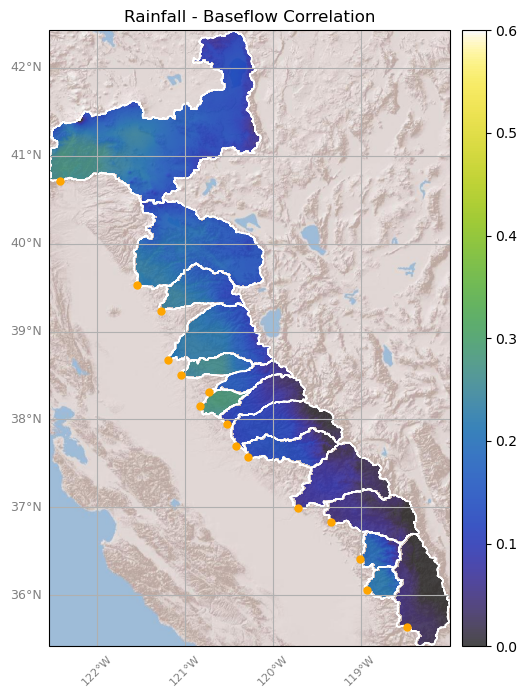

In [8]:
src = rio.open("../results/BF_XC_final/merged/prcp.tiff")
arr = src.read(1)
arr[arr==src.nodata] = np.nan

fig, axes = plt.subplots(nrows=1, ncols=1,figsize = (12,8), subplot_kw={'projection': ccrs.PlateCarree()})
im = plot_basemaps(arr, "../shape/sierra_catchments.shp", "Rainfall - Baseflow Correlation", cmap = cmap, ax = axes, latlabels = True, lonlabels = True,vmax = 0.6)
fig.subplots_adjust(wspace=0.02,hspace =0.00)
cax = fig.add_axes([axes.get_position().x1+0.01,axes.get_position().y0,0.02,axes.get_position().y1-axes.get_position().y0])
fig.colorbar(mappable = im, orientation='vertical', cax = cax,ax = axes)

plt.show()


<Axes: title={'center': '500m elevation contours '}>

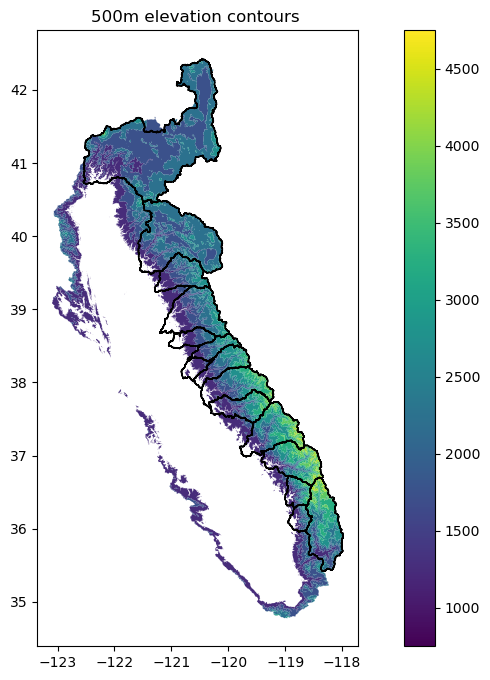

In [9]:
# ELEVATION ANALYSIS 

# Read elevation contours we made 
cont_gdf = gp.read_file("../shape/contours_500m.shp")
cont_gdf['elev'] = np.linspace(250,4750,10) # [int(x) * 500 for x in gdf['ID']] 

# Set alpha val in cmap
cmap = plt.get_cmap('viridis')
cmap.set_under('k', alpha=0)

# plot with watersehds 
ax = cont_gdf.plot(figsize = (12,8), column= 'elev',cmap = cmap, legend = True, vmin = 751)
plt.title('500m elevation contours ')
gp.read_file("../shape/sierra_catchments.shp").plot(ax = ax, facecolor = "none", edgecolor = 'black')

In [10]:
# Define the 500m contour interval 
heights = np.linspace(0,5000,11)
heights = ["{} - {}".format(str(x-500), str(x)) for x in heights]
heights[0] = "<0"

median_hts = np.linspace(250,4750,10)

# Read each contour interval shape
with fiona.open("../shape/contours_500m.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

len(shapes), len(median_hts)


(10, 10)

In [11]:
merged_dir = "../results/BF_XC_final/merged/"

# Final results dict 
elev_res_fin = {}

for vartype in ['smlt','prcp','ann_smlt','ann_prcp'][:]:
    mean_fn = os.path.join(merged_dir,vartype+".tiff")
    print(mean_fn)

    # Set up dict for elevation results
    elev_res = {}

    # Loop through elevation contours
    for idx, shape in enumerate(shapes):
        with rasterio.open(mean_fn) as src:
            out_image, out_transform = rasterio.mask.mask(src, [shape], crop=True)
            outim = out_image.reshape(out_image.shape[1],out_image.shape[2])
            outim[outim==src.nodata]=np.nan #mask nodata vals
            outim[outim<=0] = np.nan
            elev_res[heights[idx]] = outim[~np.isnan(outim)].flatten()

    # Compile summary stats for each elevation bin 
    df_rows = []
    for k,v in elev_res.items():
        varmean = np.nanmean(v)
        varstd = np.nanstd(v) #np.nanpercentile(v,66) - np.nanpercentile(v,50)
        var_n = len(~np.isnan(v)) # count non - nan elements 
        sumdf = pd.DataFrame([k,varmean,varstd,var_n]).T
        sumdf.columns = ['elev','{}_mean'.format(vartype),'{}_std'.format(vartype),'{}_num'.format(vartype)]
        df_rows.append(sumdf)

    # Concat the stats we just extracted 
    tdf = pd.concat(df_rows)
    tdf['elev'] = np.linspace(250,4750,10)
    tdf = tdf.astype(float).set_index("elev")

    elev_res_fin[vartype] = tdf


../results/BF_XC_final/merged/smlt.tiff


/var/folders/zd/rjxfh38941s3dn35jv9cdgmw0000gn/T/ipykernel_7470/2473506284.py:25: RuntimeWarning: Mean of empty slice
  varmean = np.nanmean(v)
/opt/anaconda3/envs/plotting/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


../results/BF_XC_final/merged/prcp.tiff


/var/folders/zd/rjxfh38941s3dn35jv9cdgmw0000gn/T/ipykernel_7470/2473506284.py:25: RuntimeWarning: Mean of empty slice
  varmean = np.nanmean(v)
/opt/anaconda3/envs/plotting/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


../results/BF_XC_final/merged/ann_smlt.tiff


/var/folders/zd/rjxfh38941s3dn35jv9cdgmw0000gn/T/ipykernel_7470/2473506284.py:25: RuntimeWarning: Mean of empty slice
  varmean = np.nanmean(v)
/opt/anaconda3/envs/plotting/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


../results/BF_XC_final/merged/ann_prcp.tiff


/var/folders/zd/rjxfh38941s3dn35jv9cdgmw0000gn/T/ipykernel_7470/2473506284.py:25: RuntimeWarning: Mean of empty slice
  varmean = np.nanmean(v)
/opt/anaconda3/envs/plotting/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [12]:
# get n pixels as f (elevation) by var type 

# Get number of obs for P
sdf = elev_res_fin['prcp']
pcols = [x for x in sdf.columns if "prcp" in x and "num" in x]
psdf = pd.DataFrame(sdf[pcols].mean(axis = 1))
psdf.columns =  ["prcp"]

# Get number of obs for smlt
sdf = elev_res_fin['smlt']
scols = [x for x in sdf.columns if "smlt" in x and "num" in x]
smdf = pd.DataFrame(sdf[scols].mean(axis = 1))
smdf.columns = ["smlt"]

num_df = pd.concat([psdf, smdf], axis = 1)

In [13]:
masterdf = pd.concat(elev_res_fin.values(), axis = 1)
masterdf = pd.concat(elev_res_fin.values(), axis = 1)
masterdf.to_csv("../results/xc_elev.csv")

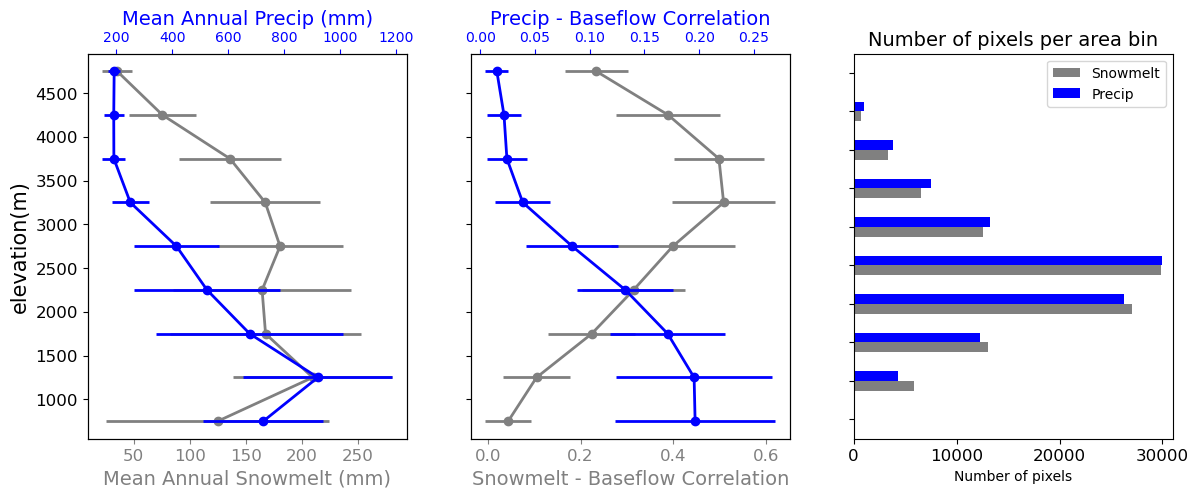

<Figure size 640x480 with 0 Axes>

In [14]:
plt.figure(figsize=(14,5))

# Means
ax0 = plt.subplot(131)
# ax0.set_title("Annual Means", size = 14)

ax0.errorbar(masterdf['ann_smlt_mean'],masterdf.index, xerr = masterdf['ann_smlt_std'], color = 'gray', label = 'snowmelt mean', linewidth = 2,marker='o')

ax0.tick_params(axis='both', which='major', labelsize=12)
ax0.set_ylabel("elevation(m)", size = 15)
ax0.set_xlabel("Mean Annual Snowmelt (mm)", size =14, color = 'gray')
ax0.tick_params(axis='x', colors='gray')

ax1 = ax0.twiny()  # instantiate a second axes that shares the same x-axis
ax1.errorbar(masterdf['ann_prcp_mean'],masterdf.index, xerr = masterdf['ann_prcp_std'], color = 'blue', label = 'snowmelt mean', linewidth = 2,marker='o')

ax1.set_xlabel("Mean Annual Precip (mm)", size =14, color = 'blue')
ax1.tick_params(axis='x', colors='blue')

# Correlation plot 
ax2 = plt.subplot(132)
# ax2.set_title("Annual Means", size = 14)

ax2.errorbar(masterdf['smlt_mean'],masterdf.index, xerr = masterdf['smlt_std'], color = 'gray', label = 'snowmelt mean', linewidth = 2,marker='o')

ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_ylabel("")
ax2.set_xlabel("Snowmelt - Baseflow Correlation", size =14, color = 'gray')
ax2.tick_params(axis='x', colors='gray')

ax3 = ax2.twiny()  # instantiate a second axes that shares the same x-axis
ax3.errorbar(masterdf['prcp_mean'],masterdf.index, xerr = masterdf['prcp_std'], color = 'blue', label = 'snowmelt mean', linewidth = 2,marker='o')

ax3.set_xlabel("Precip - Baseflow Correlation", size =14, color = 'blue')
ax3.tick_params(axis='x', colors='blue')

ax3.set(yticklabels=[])  
ax3.set_ylabel("")  

plt.subplot(133)
num_df.columns = ['Snowmelt', "Precip"]
ax4 = num_df.plot(kind = 'barh', ax = plt.gca(),color = ['gray', 'blue'])
ax4.tick_params(axis='both', which='major', labelsize=12)
ax4.set(yticklabels=[])  
ax4.set_ylabel("")  
ax4.set_xlabel("Number of pixels")  
ax4.set_title("Number of pixels per area bin", size = 14)
ax4.set_xlim([0,31000])
plt.show()

plt.tight_layout()


In [ ]:
# Make the same plots for every watershed

cor_dir = "../results/BF_xc_K180/"
mean_dir = "../results/wshed_means/"

# Final results dict 
elev_res_sheds = {}

for stid in tqdm(stids):
    
    stid_res = []
    
    for vartype in ['smlt','prcp'][:]:
        fn = os.path.join(cor_dir,stid+"_"+vartype+".tif")
        
        elev_res = {}

        # Loop through elevation contours
        for idx, shape in enumerate(shapes):
            try:
                with rasterio.open(fn) as src:
                    out_image, out_transform = rasterio.mask.mask(src, [shape], crop=True)
                    outim = out_image.reshape(out_image.shape[1],out_image.shape[2])
                    outim[outim==src.nodata]=np.nan #mask nodata vals
                    outim[outim<=0] = np.nan
                    elev_res[heights[idx]] = outim[~np.isnan(outim)].flatten()
            
            except:
                dummy_arr = np.empty(10)
                dummy_arr[:] = np.nan
                elev_res[heights[idx]] = dummy_arr
    
        # Compile summary stats for each elevation bin 
        df_rows = []
        for k,v in elev_res.items():
            varmean = np.nanmedian(v)
            varstd = np.nanstd(v) #np.nanpercentile(v,66) - np.nanpercentile(v,50)
            var_n = len(~np.isnan(v)) # count non - nan elements 
            sumdf = pd.DataFrame([k,varmean,varstd,var_n]).T
            sumdf.columns = ['elev','{}_{}_mean'.format(stid,vartype),'{}_{}_std'.format(stid,vartype),'{}_{}_num'.format(stid,vartype)]
            df_rows.append(sumdf)

        # Concat the stats we just extracted 
        tdf = pd.concat(df_rows)
        tdf['elev'] = np.linspace(250,4750,10)
        tdf = tdf.astype(float).set_index("elev")
        stid_res.append(tdf)
        
    elev_res_sheds[stid] = pd.concat(stid_res, axis =1)


  0%|                                                    | 0/15 [00:00<?, ?it/s]/var/folders/zd/rjxfh38941s3dn35jv9cdgmw0000gn/T/ipykernel_7470/3397752886.py:36: RuntimeWarning: All-NaN slice encountered
  varmean = np.nanmedian(v)
/opt/anaconda3/envs/plotting/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/zd/rjxfh38941s3dn35jv9cdgmw0000gn/T/ipykernel_7470/3397752886.py:36: RuntimeWarning: All-NaN slice encountered
  varmean = np.nanmedian(v)
/opt/anaconda3/envs/plotting/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
  7%|██▉                                         | 1/15 [00:37<08:40, 37.15s/it]/var/folders/zd/rjxfh38941s3dn35jv9cdgmw0000gn/T/ipykernel_7470/3397752886.py:36: RuntimeWarning: All-NaN slice encountered
  varmea

In [ ]:
shed_df = pd.concat(elev_res_sheds.values(), axis =1)

In [ ]:
scols = [x for x in shed_df.columns if "smlt" in x and "num" in x]
sm_num_df = pd.DataFrame(shed_df[scols])
sm_num_df.columns = [x[:3] for x in sm_num_df.columns]

In [ ]:
palette = sns.color_palette(cc.glasbey, n_colors=len(stids))

cmap_lookup = {}

for idx,x in enumerate(stids):
    cmap_lookup[x] = idx

In [ ]:
plt.figure(figsize=(14,5))

# Means
ax0 = plt.subplot(131)
ax0.set_title("Snowmelt Correlation", size = 14)

for stid in stids:
    ax0.errorbar(shed_df['{}_smlt_mean'.format(stid)],shed_df.index, xerr = shed_df['{}_smlt_std'.format(stid)], color = palette[cmap_lookup[stid]], linewidth = 1,marker='o', label = stid)

ax0.tick_params(axis='both', which='major', labelsize=12)
ax0.set_ylabel("elevation(m)", size = 15)
ax0.set_xlabel("Snowmelt Correlation", size =14)

ax1 = plt.subplot(132)
ax1.set_title("Rainfall Correlation", size = 14)

for stid in stids:
    ax1.errorbar(shed_df['{}_prcp_mean'.format(stid)],shed_df.index, xerr = shed_df['{}_prcp_std'.format(stid)],  color = palette[cmap_lookup[stid]],linewidth = 1,marker='o', label = stid)

# ax1.legend(loc = 'upper right', bbox_to_anchor = (1.25,1.05))
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_ylabel("elevation(m)", size = 15)
ax1.set_xlabel("Rainfall Correlation", size =14)
ax1.set(yticklabels=[])  
ax1.set_ylabel("")  

plt.subplot(133)
ax4 = sm_num_df.plot(kind = 'barh',ax = plt.gca(),color = palette, width = 2)
ax4.tick_params(axis='both', which='major', labelsize=12)
ax4.set(yticklabels=[])  
ax4.set_ylabel("")  
ax4.set_xlabel("Number of pixels", size = 12)  
ax4.set_title("Number of pixels per area bin", size = 14)
ax4.legend(loc = 'upper right', fontsize = 12, bbox_to_anchor = (1.28,1.03))
plt.tight_layout()


In [ ]:
# Scatterplot the mean annual value vs the correlation for each watershed

In [ ]:
sm_dfs = []
pr_dfs = []

for stid in tqdm(stids[:]):
    sm_mean_fn = os.path.join("../results/wshed_means/{}_smlt.tiff".format(stid))
    pr_mean_fn = os.path.join("../results/wshed_means/{}_prcp.tiff".format(stid))
    
    sm_cor_fn = os.path.join("../results/BF_XC_final/{}_smlt.tif".format(stid))
    pr_cor_fn = os.path.join("../results/BF_XC_final/{}_prcp.tif".format(stid))
    
    sm_t = rio.open(sm_mean_fn)
    sm_mean = sm_t.read(1)
    sm_mean[sm_mean==sm_t.nodata] = np.nan
    
    pr_t = rio.open(pr_mean_fn)
    pr_mean = sm_t.read(1)
    pr_mean[pr_mean==pr_t.nodata] = np.nan
    
    pr_c_t = rio.open(pr_cor_fn)
    pr_cor = pr_c_t.read(1)
    pr_cor[pr_cor==pr_c_t.nodata] = np.nan
    pr_cor[pr_cor<0] = np.nan
    
    sm_c_t = rio.open(sm_cor_fn)
    sm_cor = sm_c_t.read(1)
    sm_cor[sm_cor==sm_c_t.nodata] = np.nan
    sm_cor[sm_cor<0] = np.nan

    smdf = pd.DataFrame([sm_mean.flatten(),sm_cor.flatten()]).T
    smdf.columns = ['sm_mean','sm_cor']
    smdf['id'] = [stid for x in range(0,len(smdf))]
    sm_dfs.append(smdf)
    
    prdf = pd.DataFrame([pr_mean.flatten(),pr_cor.flatten()]).T
    prdf.columns = ['pr_mean','pr_cor']
    prdf['id'] = [stid for x in range(0,len(prdf))]
    pr_dfs.append(prdf)

In [ ]:
smdf_fin = pd.concat(sm_dfs, axis = 0).dropna()

In [ ]:
sns.lmplot(data=smdf_fin, x ='sm_mean', y='sm_cor',  hue='id', palette = palette, scatter_kws={'alpha':0.9})
plt.ylim([0,1])
plt.show()

In [ ]:
prdf_fin = pd.concat(pr_dfs, axis = 0).dropna()

In [ ]:
sns.lmplot( data=prdf_fin, x='pr_mean', y='pr_cor', hue='id', palette = palette, scatter_kws={'alpha':0.9})
plt.ylim([0,0.5])

In [ ]:
# Snowmelt / Rainfall dominance plot 

src = rio.open("../results/BF_XC_final/merged/prcp.tiff")
prcp= src.read(1)
prcp[prcp==src.nodata] = np.nan

src = rio.open("../results/BF_XC_final/merged/smlt.tiff")
smlt = src.read(1)
smlt[smlt==src.nodata] = np.nan

dom_arr = np.zeros_like(prcp)
dom_arr[smlt>=prcp] = 1
dom_arr[smlt<prcp] = -1
dom_arr[dom_arr==0] = np.nan
dom_arr[dom_arr==-1] = 0

In [ ]:
plt.imshow(dom_arr, cmap = plt.cm.get_cmap('Set2', 2), vmin = 0, vmax = 1); 
cbar = plt.colorbar(); 

#legend
cbar.ax.get_yaxis().set_ticks([])
yticks = np.linspace(*cbar.ax.get_ylim(), 3)[1:]
cbar.set_ticks(yticks, labels=['        Rain Dominated','        Snow Dominated'], rotation= 270)

plt.show()

In [ ]:
# Rain vs snow dominance 

def plot_basemaps(image, shp, title = None, cmap = plt.cm.get_cmap('tab20', 2), ax = None, latlabels = True, lonlabels = True, vmax = None):
    imextent = gp.read_file(shp).set_crs("EPSG:4326").to_crs(4326).total_bounds
    shape_feature = ShapelyFeature(Reader("../shape/sierra_catchments.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='white', facecolor = 'none')

    minx, miny, maxx, maxy = imextent
    lllon, lllat = minx, miny
    urlon, urlat = maxx, maxy

    # Create a Stamen Terrain instance.
    stamen_terrain = cimgt.GoogleTiles(style='terrain', url = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Shaded_Relief/MapServer/tile/{z}/{y}/{x}.jpg')

    # Create a GeoAxes in the tile's projection.
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels= False
    gl.right_labels = False
    if not latlabels:
        gl.left_labels = False
    if not lonlabels:
        gl.bottom_labels = False
    
    gl.xlocator = mticker.FixedLocator([-122,-121,-120,-119])
    gl.ylocator = mticker.FixedLocator(np.linspace(0,90,91))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 8, 'color': 'gray', 'rotation': 45}
    gl.ylabel_style = {'size': 9, 'color': 'gray'}

    # Limit the extent of the map to a small longitude/latitude range.
    ax.set_extent([lllon, urlon, lllat, urlat])

    # Add the Stamen data at zoom level 8.
    ax.add_image(stamen_terrain, 8)

    # Plot image
    im = ax.imshow(image,
        cmap=cmap, zorder=1, vmin = 0, vmax = vmax,
        origin="upper", alpha = 0.8,
        extent=(lllon, urlon, lllat, urlat),
        transform=ccrs.PlateCarree(),
    )

    cbar = fig.colorbar(im); 

    #legend
    cbar.ax.get_yaxis().set_ticks([])
    yticks = np.linspace(*cbar.ax.get_ylim(), 3)[1:]
    cbar.set_ticks(yticks, labels=['        Rain Dominated','        Snow Dominated'], rotation= 270)

    # Add shapefile outline
    ax.add_feature(shape_feature, zorder = 2)
    
    points = list(Reader("../shape/trm_res_fnf.shp").geometries())

    ax.scatter([point.x for point in points],
               [point.y for point in points],
               transform=ccrs.PlateCarree(), color= 'orange', s = 25, zorder = 10)
        
    # Set the title
    ax.set_title("{}".format(title), size = 12)

    return im


# Snowmelt / Rainfall dominance plot 

src = rio.open("../results/BF_XC_final/merged/prcp.tiff")
prcp= src.read(1)
prcp[prcp==src.nodata] = np.nan

src = rio.open("../results/BF_XC_final/merged/smlt.tiff")
smlt = src.read(1)
smlt[smlt==src.nodata] = np.nan

dom_arr = np.zeros_like(prcp)
dom_arr[smlt>=prcp] = 1
dom_arr[smlt<prcp] = -1
dom_arr[dom_arr==0] = np.nan
dom_arr[dom_arr==-1] = 0

fig, axes = plt.subplots(nrows=1, ncols=1,figsize = (12,8), subplot_kw={'projection': ccrs.PlateCarree()})
im = plot_basemaps(dom_arr, "../shape/sierra_catchments.shp", "Rainfall / Snowmelt Dominance (Cross Correlation)", ax = axes, latlabels = True, lonlabels = True,vmax = 1)
fig.subplots_adjust(wspace=0.02,hspace =0.00)

plt.show()


